<a href="https://colab.research.google.com/github/sunfflur/frequency-learning/blob/master/cataract-detection/Exp_Retina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cataract detection

`Author:` [sunfflur](https://github.com/sunfflur)

> This experiment uses the 2 classes from Cataract detection dataset divided in 75% / 25% with *512x512* pixels each image.


---

#### Libraries Import

In [ ]:
s = 23
import os
os.environ['PYTHONHASHSEED']=str(s)
import random
random.seed(s)
from numpy.random import seed
seed(s)
from tensorflow.random import set_seed
set_seed(s)

import PIL
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Conv1D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import time

!pip install tensorflow-addons 
!pip install tensorflow-recommenders

import tensorflow_addons as tfa
import tensorflow_recommenders as tfrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 29 15:42:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#### Drive mount

In [ ]:
### TESSSSSST ###

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 123947 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-36build1_amd64.deb ...
Unpacking w3m (0.5.3-36build1) ...
Setting up w3m (0.5.3-36build1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


#### Data preparation

In [ ]:
### data loading ### 
path_train = '/content/drive/MyDrive/Mestrado/Datasets/retina/retina-dataset/retina_train.npy'
path_ytrain = '/content/drive/MyDrive/Mestrado/Datasets/retina/retina-dataset/retina_y_train.npy'
path_test = '/content/drive/MyDrive/Mestrado/Datasets/retina/retina-dataset/retina_test.npy'
path_ytest = '/content/drive/MyDrive/Mestrado/Datasets/retina/retina-dataset/retina_y_test.npy'

x_train, x_test = np.load(path_train), np.load(path_test)
y_train, y_test = np.load(path_ytrain), np.load(path_ytest)

#x_train_ = tf.image.rgb_to_grayscale(x_train)
#x_test_ = tf.image.rgb_to_grayscale(x_test)
#x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)

# adjust dimension and change from array to tensor
#new_shape = (512,512)
#x_train, x_test = tf.image.resize_with_pad(x_train, new_shape), tf.image.resize(x_test, new_shape)
y_train, y_test = tf.stack(to_categorical(y_train)), tf.stack(to_categorical(y_test))

In [ ]:
x_train_ = tf.image.rgb_to_grayscale(x_train)

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


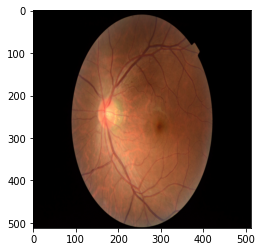

In [ ]:
ex = 5

print(y_train[ex]) #normal=[1,0]; catarata=[0,1]
plt.imshow(tf.squeeze(x_train[ex]), cmap='gray')
plt.show()

#### Image Main Functions - Per Image

In [ ]:
### blocks PER IMAGE ###
def slice_data(images, levels):
  outputs = []
  if levels == 0:
    dim = int(tf.rank(images))
    if dim == 3:
      #print(images.shape)
      images = tf.expand_dims(images, -1)
      images = tf.transpose(images, [0, 3, 1, 2])
      return images
    else:
      images = tf.transpose(images, [0, 3, 1, 2])
      return images
  for image in images:
    #print('image shape?', image.shape)
    iM, iN = image.shape[0], image.shape[1] #512,512
    iMc, iNc = int(iM/2), int(iN/2) #512/2,512/2
    output = tf.stack((image[:iMc, :iNc], image[:iMc,iNc:], image[iMc:,:iNc], image[iMc:, iNc:]),-1)
    output = tf.reshape(output,[output.shape[0],output.shape[1], -1]) #256,256,4
    outputs.append(output)
  outputs = tf.convert_to_tensor(outputs)
  return slice_data(outputs, levels-1)

In [ ]:
### DFT PER IMAGE ### 
def m_spectrum(images):
  magnitudes = []
  for image in images:
    side = image.shape[1]
    inputx = tf.cast(image, tf.complex128) # change dtype to complex64
    fft = tf.signal.fft2d(inputx) # perform fast fourier transform
    fft_shift = tf.signal.fftshift(fft, axes=(1,2)) # shift the zero-frequency component to the center
    # calculate the magnitude and scale it
    magnitude = tf.math.abs(fft_shift)
    magnitude = tf.math.divide(magnitude, side**2) # do not change here !!!
    magnitude = tf.math.log(1+magnitude)
    magnitudes.append(magnitude)
  return tf.convert_to_tensor(magnitudes)

In [ ]:
def NormalizeData(X, max=1, min=0):
    ### data normalization between 0-1
    X_std = (X - tf.math.reduce_min(X)) / (tf.math.reduce_max(X) - tf.math.reduce_min(X))
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [ ]:
### magnitude sums PER IMAGE ###
def radial_grouping(images, r):
  grouping = []
  for image in images:
    iM, iN = image.shape[1], image.shape[2] #image dimension
    iMc, iNc = int(iM/2), int(iN/2) #image center
    A = tf.range(-iMc,iNc)**2
    dists = tf.math.sqrt(tf.cast(A[:,None] + A, dtype=tf.float64))
    dists = tf.reshape(dists, [1,image.shape[1],image.shape[2]]) #1,512,512
    n = int(iNc/r) #rings number
    magnitude_sums = []
    ring = 0
    for j in range(1, 2*n, 2):
      ring = tf.cast((tf.abs(dists-(r/2)*j)<(r/2)), dtype=tf.float64)
      if j == 1:
        ring = tf.cast((tf.abs(dists-(r/2)*j)<=(r/2)), dtype=tf.float64)
      mult = tf.multiply(ring,image)
      sum = tf.reduce_sum(mult,axis=(1,2))
      magnitude_sums.append(sum.numpy())
    magnitude_sums = tf.convert_to_tensor(magnitude_sums)
    grouping.append(magnitude_sums)
  grouping = tf.convert_to_tensor(grouping)
  grouping = tf.reshape(grouping, [grouping.shape[0], -1])
  return grouping

In [ ]:
### magnitude sums PER IMAGE ###
def square_grouping(images, r):
  grouping = []
  for image in images:
    iM, iN = image.shape[1], image.shape[2] #image dimension
    iMc, iNc = int(iM/2), int(iN/2) #image center
    A = tf.range(-iMc,iNc)**2
    n = int(iNc/r) #rings number
    ring = np.full((iM,iN), 0)
    magnitude_sums = []
    for w in range(r, (n*r)+1, r):
      ring[iMc-w:iMc+w,iNc-w:iNc+w] = 1
      ring[iMc-w + r :iMc+w -r ,iNc-w +r :iNc+w -r] = 0
      mult = tf.multiply(ring, image)
      #print('mult:', mult)
      sum = tf.reduce_sum(mult,axis=(1,2))
      magnitude_sums.append(sum.numpy())
    magnitude_sums = tf.convert_to_tensor(magnitude_sums)
    grouping.append(magnitude_sums)
  grouping = tf.convert_to_tensor(grouping)
  grouping = tf.reshape(grouping, [grouping.shape[0], -1])
  return grouping

#### Data Pre-Process - 3 levels

In [ ]:
class PreProcess():
  def __init__(self, data, level, r): #level = levels number; r = radius (ring width);
    self.data = data #x_train/test
    self.level = level
    self.r = r
  def processing(self):
    conc_channels = []
    for i in range(0, self.level+1):
      print('level:', i)
      for j in range(0, self.data.shape[3]):
        print('channel:', j)
        sliced_data = slice(self.data[:,:,:,j], levels=i)
        #print('sliced:', sliced_data.shape)
        dft_data = m_spectrum(sliced_data)
        #grouping_data = radial_grouping(dft_data, r=self.r) # r = radius (ring width)
        grouping_data = square_grouping(dft_data, r=self.r) # r = radius (ring width)
        conc_channels.append(grouping_data)
        #del sliced_data
        #del dft_data
        #del grouping_data
      conc = tf.concat((conc_channels), axis=1)
    input = tf.concat((conc), axis=1)
    #print(input.shape)
    #print('input:',input)
    ### data normalization between 0-1
    #scaler = MinMaxScaler()
    #inp = scaler.fit_transform(input) #N,weights 
    inp = NormalizeData(input)
    input = tf.convert_to_tensor(inp)
    return input, sliced_data, dft_data

In [ ]:
with tf.device('/CPU:0'):
  input, sliced_data, dft_data = PreProcess(x_train, 2, 1).processing() #2 levels means original image + division in 4 blocks + division in 16 blocks (4 blocks again)

level: 0
channel: 0
level: 1
channel: 0
level: 2
channel: 0


In [ ]:
input.shape # 256*3 = 768

TensorShape([300, 1792])

In [ ]:
sliced_data.shape

TensorShape([300, 16, 128, 128])

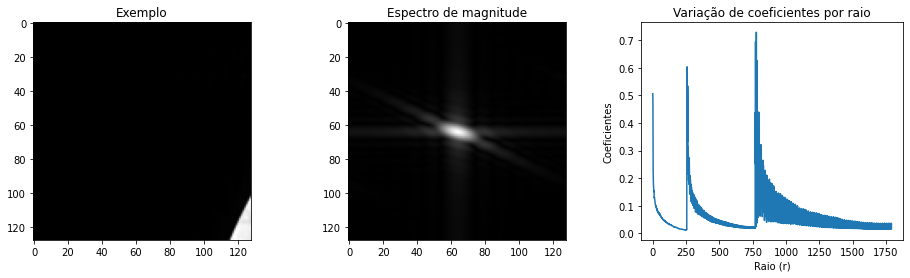

In [ ]:
example = 5
block = 0
x = input[example]

plt.figure(figsize=(16,4))
plt.subplot(131), plt.imshow(sliced_data[example, block,:,:], cmap='gray')
plt.title('Exemplo')
plt.subplot(132), plt.imshow(dft_data[example, block,:,:], cmap='gray')
plt.title('Espectro de magnitude')
plt.subplot(133), plt.plot(x)
plt.title('Variação de coeficientes por raio'), plt.xlabel('Raio (r)'), plt.ylabel('Coeficientes')
plt.show()

In [ ]:
with tf.device('/CPU:0'):
  input_test, sliced_data_test, dft_data_test = PreProcess(x_test, 2, 1).processing()

level: 0
channel: 0
level: 1
channel: 0
level: 2
channel: 0


In [ ]:
input_test.shape ### test set shape 

TensorShape([100, 1792])

In [ ]:
sliced_data_test.shape #ultima parte do pre-processamento: 16 blocos 144x144

TensorShape([100, 16, 128, 128])

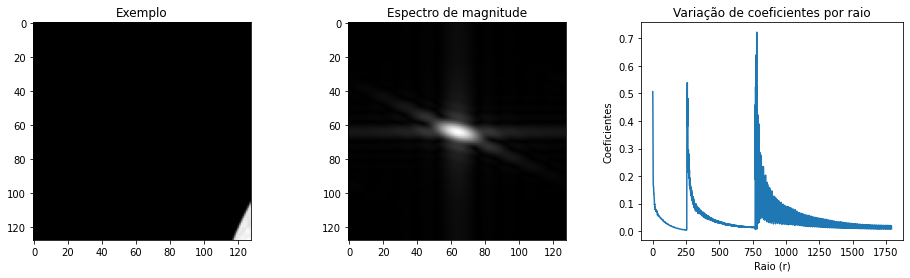

In [ ]:
example = 12
block = 0
x = input_test[example]

plt.figure(figsize=(16,4))
plt.subplot(131), plt.imshow(sliced_data_test[example, block,:,:], cmap='gray')
plt.title('Exemplo')
plt.subplot(132), plt.imshow(dft_data_test[example, block,:,:], cmap='gray')
plt.title('Espectro de magnitude')
plt.subplot(133), plt.plot(x)
plt.title('Variação de coeficientes por raio'), plt.xlabel('Raio (r)'), plt.ylabel('Coeficientes')
plt.show()

#### Data Load

In [ ]:
### Saved Pre-Processed data LOAD ###
input = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Experimentos/exp-retina/exp-retina-data/square-grouping/1_level/input_train_retina_gray_l2_w1_square.npy'))
input_test = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Experimentos/exp-retina/exp-retina-data/square-grouping/1_level/input_test_retina_gray_l2_w1_square.npy'))

#input = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Datasets/exp-retina/exp-retina-data/square-grouping/1_level/input_train_retina_l0_w1_square.npy')) ### train
#input_test = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Datasets/exp-retina/exp-retina-data/square-grouping/1_level/input_test_retina_l0_w1_square.npy')) ### test

In [ ]:
input.shape

TensorShape([300, 1792])

#### Custom Layer

In [ ]:
### frequency layer constrution ###

class FreqLayer(Layer):
  def __init__(self, units, kernel_initializer=None, extra_layers='Dense', output_type='Dense', **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.kernel_initializer = kernel_initializer
    self.extra_layers = extra_layers
    self.output_type = output_type
  def build(self, batch_input_shape):
    if self.extra_layers == 'Dense':
      shape = [batch_input_shape[-1]] #(weights,) - shape for dense training
    else:
      shape = [batch_input_shape[-2],1] #(weights, 1) - shape for convolutional training
    self.kernel = self.add_weight(
        name='kernel',
        shape = shape,
        initializer=self.kernel_initializer,
        trainable=True)
    super().build(batch_input_shape) # must be at the end
  def call(self, X):
    #### fourier convolution ####
    f = X*self.kernel
    return f
  def compute_output_shape(self, batch_input_shape):
    if self.output_type == 'Dense':
      return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units]) #[examples,1] - dense
    else:
      return tf.TensorShape(batch_input_shape.as_list()[:-2] + [self.units]) #[examples,1] - conv1d

#### Model

In [ ]:
### dense ###
tf.random.set_seed(11) #s
init = 'glorot_normal' #glorot_uniform 84%
function = 'LeakyReLU'
#function = tf.keras.layers.LeakyReLU(alpha=0.01)

model = Sequential([
    FreqLayer(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=0.0001)), #-2, 0.01
    Dense(4, activation=function,
          kernel_initializer=init, bias_initializer=init),
    #Dropout(0.1),
    #Dense(4, activation=function,
    #     kernel_initializer=init, bias_initializer=init),
    Dense(2, activation='softmax')])

In [ ]:
### inverse time decay  ###
bs=10
inversetime_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate = 0.1, #0.01
  decay_steps = input.shape[0]/bs,
  decay_rate = 0.1) #0.1

### optimizers ###
d_m=0.9 #momentum - dense layers #0.1

#opt1 = SGD(learning_rate=inversetime_decay, momentum=0.3) #84

opt2 = tfrs.experimental.optimizers.CompositeOptimizer([
      (SGD(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      #(SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      #(SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights)]) #86

opt3 = Adam(learning_rate=inversetime_decay)

model.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=500) # patience = 15
history = model.fit(input, y_train, epochs=250, batch_size=bs, verbose=1, shuffle=True) #validation_split=0.1

Epoch 1/250
30/30 [==============================] - 0s 2ms/step - loss: 0.6342 - accuracy: 0.7000
Epoch 2/250
30/30 [==============================] - 0s 2ms/step - loss: 0.5806 - accuracy: 0.7400
Epoch 3/250
30/30 [==============================] - 0s 2ms/step - loss: 0.5963 - accuracy: 0.7400
Epoch 4/250
30/30 [==============================] - 0s 2ms/step - loss: 0.5903 - accuracy: 0.7400
Epoch 5/250
30/30 [==============================] - 0s 2ms/step - loss: 0.5858 - accuracy: 0.7400
Epoch 6/250
30/30 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.7400
Epoch 7/250
30/30 [==============================] - 0s 3ms/step - loss: 0.5827 - accuracy: 0.7400
Epoch 8/250
30/30 [==============================] - 0s 2ms/step - loss: 0.5794 - accuracy: 0.7400
Epoch 9/250
30/30 [==============================] - 0s 2ms/step - loss: 0.5756 - accuracy: 0.7400
Epoch 10/250
30/30 [==============================] - 0s 2ms/step - loss: 0.5756 - accuracy: 0.7400
Epoch 11/

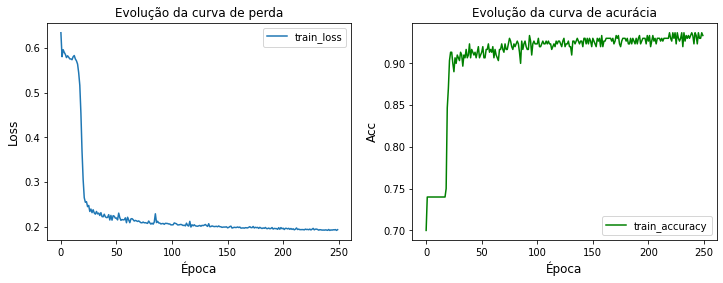

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='train_loss')
#plt.subplot(121), plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'train_accuracy', color='green')
#plt.subplot(122), plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ###
scores = model.evaluate(input_test, y_test)
print('\n%s : %.2f%%' % (model.metrics_names[1], scores[1] * 100))

4/4 [==============================] - 0s 3ms/step - loss: 0.2757 - accuracy: 0.9300

accuracy : 93.00%


4/4 [==============================] - 0s 2ms/step


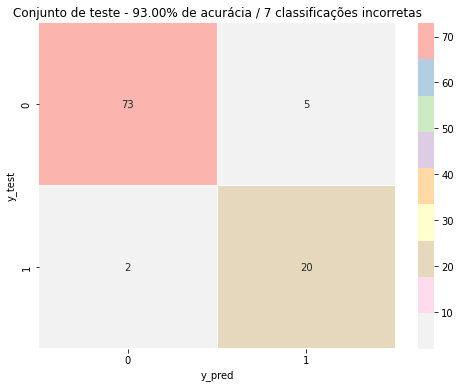

In [ ]:
y_pred = model.predict(input_test)
plt.figure(figsize = (8,6))
cm = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))
acc = np.trace(cm)/input_test.shape[0] * 100
erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros))
sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
dic = {0:'normal',1:'cataract'} #normal=[1,0]; catarata=[0,1]

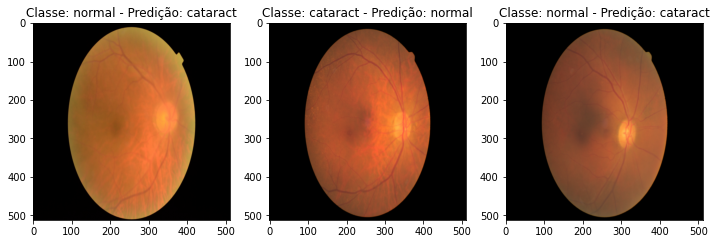

In [ ]:
dif = tf.argmax(y_test, axis=1)-tf.argmax(y_pred, axis=1)
indices = np.where(dif!=0)[0]

plt.figure(figsize=(12,6))
plt.subplot(131), plt.imshow(tf.squeeze(x_test[indices[0]]), cmap='gray')
r1 = tf.argmax(y_test, axis=1)[indices[0]]
f1 = tf.argmax(y_pred, axis=1)[indices[0]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r1)], dic[int(f1)]))
plt.subplot(132), plt.imshow(tf.squeeze(x_test[indices[1]]), cmap='gray')
r2 = tf.argmax(y_test, axis=1)[indices[1]]
f2 = tf.argmax(y_pred, axis=1)[indices[1]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r2)], dic[int(f2)]))
plt.subplot(133), plt.imshow(tf.squeeze(x_test[indices[2]]), cmap='gray')
r3 = tf.argmax(y_test, axis=1)[indices[2]]
f3 = tf.argmax(y_pred, axis=1)[indices[2]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r3)], dic[int(f3)]))
plt.show()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 freq_layer_2 (FreqLayer)    (None, 1792)              1792      
                                                                 
 dense_4 (Dense)             (None, 4)                 7172      
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
Total params: 8,974
Trainable params: 8,974
Non-trainable params: 0
_________________________________________________________________


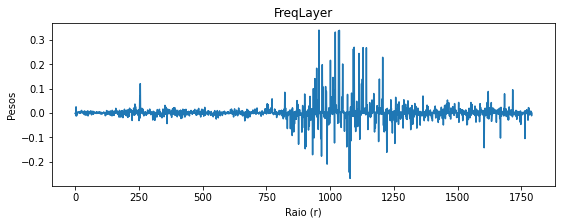

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(model.get_weights()[0])
plt.title('FreqLayer')
plt.xlabel('Raio (r)'), plt.ylabel('Pesos')
plt.show()